In [7]:
import sys
import os
configDir =  '/home/thibaud/repos/anaconda/rakuten/notebook'
if configDir not in sys.path:
    sys.path.append(configDir)

import config

import multiprocessing
num_cores = multiprocessing.cpu_count()


import pandas as pd
import numpy as np
import tensorflow as tf

from src.text.classifiers import TFbertClassifier
from src.image.classifiers import ImgClassifier
from src.multimodal.classifiers import TFmultiClassifier

from src.utils.batch import fit_save_all
from src.utils.plot import plot_training_history

import datetime

In [8]:
def Rakuten_img_path(img_folder, imageid, productid, suffix=''):
    """ retrurns the path to the image of a given productid and imageid"""

    df = pd.DataFrame(pd.concat([imageid, productid], axis=1))

    img_path = df.apply(lambda row:
                        os.path.join(img_folder, 'image_'
                                     + str(row['imageid'])
                                     + '_product_'
                                     + str(row['productid'])
                                     + suffix
                                     + '.jpg'),
                        axis=1)

    return img_path

In [9]:
data_train = pd.read_csv(os.path.join(config.path_to_data, 'df_train_index.csv'))
data_train['testset'] = False
data_test = pd.read_csv(os.path.join(config.path_to_data, 'df_test_index.csv'))
data_test['testset'] = True
data = pd.concat([data_train, data_test], axis=0)

#merging text into token column
colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
data['tokens'] = data[colnames].apply(lambda row: ' '.join(s.lower() for s in row if isinstance(s, str)), axis=1)

#path to images into img_path column
data['img_path'] = Rakuten_img_path(img_folder=config.path_to_images,
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')

In [10]:
#labels of encoded classes
class_labels = data.groupby('prdtypedesignation')['prdtypeindex'].first().reset_index()
class_labels.index = class_labels['prdtypeindex']
class_labels = class_labels.drop(columns='prdtypeindex').sort_index()

## Creating train and test sets

In [11]:
Img_train = data.loc[~data['testset'], 'img_path']
Img_test = data.loc[data['testset'], 'img_path']

Txt_train = data.loc[~data['testset'], 'tokens']
Txt_test = data.loc[data['testset'], 'tokens']

y_train = data.loc[~data['testset'],'prdtypeindex']
y_test = data.loc[data['testset'],'prdtypeindex']

#To be fed into any of our sklearn classifiers, X_train and X_test
#should be dataframes with columns tokens and img_path
X_train = pd.DataFrame({'tokens': Txt_train, 'img_path': Img_train})
X_test = pd.DataFrame({'tokens': Txt_test, 'img_path': Img_test})

#All data for cross-validated scores
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

#Number of classes
num_classes = len(np.unique(data['prdtypeindex']))
X_test.head()

,tokens,img_path
0,bas de filles pour les enfants enfants collant...,/home/thibaud/repos/anaconda/rakuten/data/imag...
1,cosmic planète series en peluche avec capuche ...,/home/thibaud/repos/anaconda/rakuten/data/imag...
2,dolphin - robot électrique de piscine fond par...,/home/thibaud/repos/anaconda/rakuten/data/imag...
3,haydaim 14/114 pokemon noir et blanc,/home/thibaud/repos/anaconda/rakuten/data/imag...
4,lot 4 livres partitions piano bach (busoni) - ...,/home/thibaud/repos/anaconda/rakuten/data/imag...


In [7]:
# model = MLClassifier(base_name='LogisticRegression', vec_method='tfidf')
# model = model.load('LogisticRegression_tfidf')
# model.predict(X_test)

# CBOW benchmark

In [16]:
import src.text.cbow_vectorizer as cbow
import src.utils.plot as uplot
from sklearn.experimental import enable_halving_search_cv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.pipeline import Pipeline


vcbow = cbow.CBowVectorizer()
model = LogisticRegression()
pipeline = Pipeline([
    ('cbow', vcbow),
    ('logreg', model)
])
# vector_size=500, window=10, min_count=2, workers=4
param_grid = {
    'cbow__vector_size': [100],
    'cbow__window': [10],
    'cbow__min_count': [2, 3, 4],
    'cbow__workers': [14],
    'logreg__C': [0.1, 1, 10],
    'logreg__max_iter': [2000]
}


grid = HalvingGridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=14)

grid.fit(X_train['tokens'], y_train)

best_params = grid.best_params_
best_score = grid.best_score_

print("Meilleurs hyperparamètres :", best_params)
print("Meilleur score :", best_score)



# Meilleurs hyperparamètres : {'cbow__min_count': 2, 'cbow__vector_size': 300, 'cbow__window': 10, 'cbow__workers': 14, 'logreg__C': 0.1, 'logreg__max_iter': 2000}
# Meilleur score : 0.6876582464817759

# Meilleurs hyperparamètres : {'cbow__min_count': 3, 'cbow__vector_size': 100, 'cbow__window': 10, 'cbow__workers': 14, 'logreg__C': 10, 'logreg__max_iter': 2000}
# Meilleur score : 0.6853323912147441


Meilleurs hyperparamètres : {'cbow__min_count': 3, 'cbow__vector_size': 100, 'cbow__window': 10, 'cbow__workers': 14, 'logreg__C': 10, 'logreg__max_iter': 2000}
Meilleur score : 0.6853323912147441


In [ ]:
y_pred = grid.predict(X_test)

uplot.classification_results(y_test, y_pred, class_labels, 'LogisticRegression_cbow')

In [6]:
from src.utils.load import load_classifier
from src.text.classifiers import MLClassifier
svc_tfidf_classifier = MLClassifier()
svc_tfidf_classifier = load_classifier('text/LinearSVC_tfidf')
y_pred_tfidf = svc_tfidf_classifier.predict(X_test)

/home/thibaud/intel/oneapi/intelpython/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.2.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/thibaud/intel/oneapi/intelpython/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/thibaud/intel/oneapi/intelpython/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning:

                                precision    recall  f1-score   support

               Livres occasion       0.53      0.52      0.52       623
Figurines et objet pop culture       0.78      0.79      0.79       534
                Cartes de jeux       0.91      0.96      0.93       791
     Figurines et jeux de rôle       0.81      0.56      0.66       153
                Jouets enfants       0.72      0.66      0.69       974
       Jeux de société enfants       0.70      0.55      0.62       414
               Jeux techniques       0.87      0.96      0.91      1009
              Vêtements enfant       0.97      0.96      0.97       161
                         Pêche       0.83      0.81      0.82       498
                  Puériculture       0.86      0.81      0.83       648
                      Mobilier       0.82      0.84      0.83      1015
               Linge de maison       0.89      0.92      0.91       861
                   Confiseries       0.87      0.95      0.91  

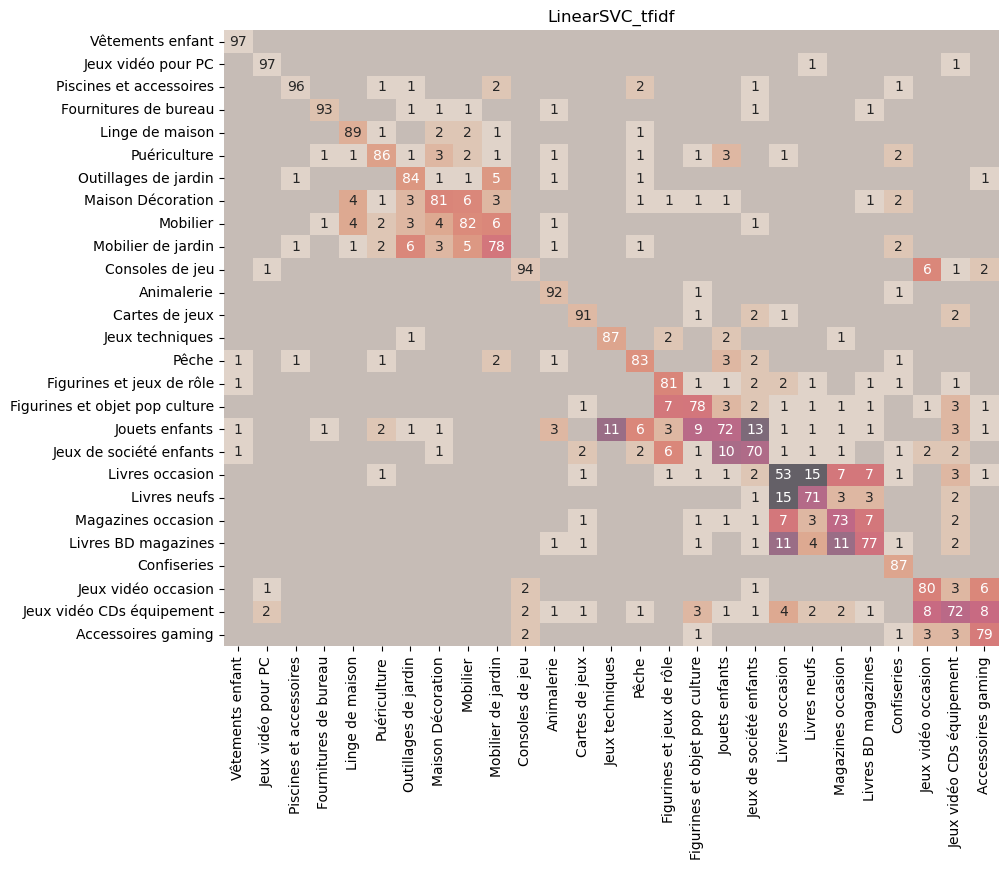

<module 'matplotlib.pyplot' from '/home/thibaud/intel/oneapi/intelpython/envs/tensorflow/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [33]:
import src.utils.plot as uplot
from importlib import reload

reload(uplot)
class_labels.prdtypedesignation.values
uplot.classification_results(y_test, y_pred_tfidf, class_labels.prdtypedesignation.values, 'LinearSVC_tfidf')

In [12]:
from src.utils.load import load_classifier
from src.text.classifiers import MLClassifier
svc_skip_classifier = MLClassifier()
svc_skip_classifier = load_classifier('text/SVC_skipgram')
y_pred_skip = svc_skip_classifier.predict(X_test)

/home/thibaud/intel/oneapi/intelpython/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.2.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
import src.utils.plot as uplot
from importlib import reload

uplot.compare_confusion_matrix(y_test, y_pred_tfidf, y_pred_skip, class_labels, 'LinearSVC_tfidf', 'SVC_skipgram')

AttributeError: module 'src.utils.plot' has no attribute 'compare_confusion_matrix'

In [15]:
import src.utils.load as uload
reload(uload)

test= uload.load_batch_results('results_benchmark_img')

In [17]:
display(test)

/home/thibaud/intel/oneapi/intelpython/envs/tensorflow/lib/python3.9/site-packages/pandas/io/formats/format.py:1595: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/home/thibaud/intel/oneapi/intelpython/envs/tensorflow/lib/python3.9/site-packages/pandas/io/formats/format.py:1596: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/home/thibaud/intel/oneapi/intelpython/envs/tensorflow/lib/python3.9/site-packages/pandas/io/formats/format.py:1596: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,modality,class,vectorization,classifier,tested_params,best_params,score_test,score_test_cat,conf_mat_test,score_train,fit_time,score_cv_test,score_cv_train,fit_cv_time,probs_test,pred_test,y_test,model_path
0,image,ImgClassifier,NaN,vit_b16,"{'img_size': [(224, 224, 3)], 'num_class': [27...",NaN,0.674881,"[0.5650406504065042, 0.6854368932038835, 0.945...","[[417, 1, 3, 0, 3, 9, 2, 0, 0, 1, 0, 1, 0, 8, ...",NaN,10572.723924,NaN,NaN,NaN,"[[8.292947200061462e-07, 0.0001000832853605970...","[4, 13, 20, 2, 0, 0, 13, 20, 18, 23, 18, 15, 1...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...",image/vit_b16
1,image,ImgClassifier,NaN,ResNet152,"{'img_size': [(224, 224, 3)], 'num_class': [27...",NaN,0.657804,"[0.5566218809980806, 0.66015625, 0.93164556962...","[[435, 1, 2, 3, 3, 10, 5, 1, 0, 1, 2, 2, 1, 6,...",NaN,6894.601873,NaN,NaN,NaN,"[[8.958209946285933e-05, 0.0009164343937300146...","[7, 13, 20, 2, 16, 22, 13, 20, 4, 23, 24, 15, ...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...",image/ResNet152
2,image,ImgClassifier,NaN,ResNet101,"{'img_size': [(224, 224, 3)], 'num_class': [27...",NaN,0.656428,"[0.5465253239104829, 0.6710650329877473, 0.931...","[[464, 1, 2, 2, 1, 6, 3, 0, 1, 3, 0, 2, 0, 8, ...",NaN,6754.401560,NaN,NaN,NaN,"[[5.9572659665718675e-05, 0.003772339317947626...","[8, 13, 20, 2, 0, 22, 13, 20, 13, 23, 0, 15, 1...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...",image/ResNet101
3,image,ImgClassifier,NaN,EfficientNetB1,"{'img_size': [(224, 224, 3)], 'num_class': [27...",NaN,0.655350,"[0.5469135802469136, 0.6673366834170854, 0.925...","[[443, 1, 3, 1, 5, 3, 4, 0, 0, 1, 1, 0, 1, 12,...",NaN,6657.913207,NaN,NaN,NaN,"[[0.001487365341745317, 0.021663466468453407, ...","[14, 11, 20, 2, 0, 0, 13, 20, 1, 23, 4, 15, 18...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...",image/EfficientNetB1
4,image,ImgClassifier,NaN,ResNet50,"{'img_size': [(224, 224, 3)], 'num_class': [27...",NaN,0.653463,"[0.5648379052369077, 0.6598569969356487, 0.922...","[[453, 1, 5, 0, 4, 4, 1, 1, 0, 4, 1, 3, 0, 6, ...",NaN,6720.913614,NaN,NaN,NaN,"[[8.77557322382927e-05, 0.0033385390415787697,...","[7, 13, 20, 2, 0, 0, 13, 20, 13, 23, 16, 15, 1...","[7, 10, 20, 2, 16, 0, 13, 20, 24, 23, 4, 15, 1...",image/ResNet50


## Dummy classifier

In [10]:
#Dummy classifier on tfidf
# dum_classifier = MLClassifier(base_name='dummyclassifier')
# dum_classifier.fit(X_train, y_train);
# dum_classifier.classification_score(X_test, y_test)
# cv_scores = dum_classifier.cross_validate(X, y, cv=10)
# dum_classifier.save('text/dummy')

## Bag of word based benchmarks

In [6]:
params_list = []
class_type = 'MLClassifier'

#grid search number of folds
nfolds_grid = 0

#cross-validation of f1-score
nfolds_cv = 0

#Bag of word parameters
vec_method = 'tfidf'

params_list.append({'modality': 'text',
                    'class': class_type,
                    'base_name': 'LogisticRegression', 
                    'vec_method': vec_method, 
                    'param_grid': {'C': [0.1, 1, 2], 'penalty': ['l2'], 'max_iter': [2000]},
                    'nfolds_grid': 3, 'nfolds_cv': nfolds_cv
                   })
# params_list.append({'modality': 'text',
#                     'class': class_type,
#                     'base_name': 'MultinomialNB', 
#                     'vec_method': vec_method, 
#                     'param_grid': {'alpha': [0.02], 'fit_prior': [True]},
#                     'nfolds_grid': nfolds_grid, 'nfolds_cv': nfolds_cv
# #                     })
# params_list.append({'modality': 'text',
#                     'class': class_type,
#                     'base_name': 'RandomForestClassifier', 
#                     'vec_method': vec_method, 
#                     'param_grid': {'n_estimators': [200], 'max_depth': [500,1000]},
#                     'nfolds_grid': 0, 'nfolds_cv': 0
#                     })
# params_list.append({'modality': 'text',
#                     'class': class_type,
#                     'base_name': 'xgboost', 
#                     'vec_method': vec_method, 
#                     'param_grid': {'n_estimators': [200], 'objective': ['multi:softprob'], 'max_depth':[6], 'reg_alpha':[0]},
#                     'nfolds_grid': nfolds_grid, 'nfolds_cv': nfolds_cv
#                     })
# params_list.append({'modality': 'text',
#                     'class': class_type,
#                     'base_name': 'LinearSVC', 
#                     'vec_method': vec_method, 
#                     'param_grid': {'C': np.arange(0.5, 1.5, 0.1), 'penalty': ['l2']},
#                     'nfolds_grid': 5, 'nfolds_cv': 10
#                     })

results = fit_save_all(params_list, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, result_file_name = 'results_benchmark_text.csv')


Fitting:  LogisticRegression tfidf
{'C': 0.1, 'penalty': 'l2', 'max_iter': 2000}
GridSearch:  {'C': 0.1, 'max_iter': 2000, 'penalty': 'l2'}
Test set, f1score:  0.6817626342598585


In [ ]:
# 3min57 Halving
# Fitting:  LogisticRegression tfidf
# {'C': 0.1, 'penalty': 'l2', 'max_iter': 2000}
# GridSearch:  {'C': 2, 'max_iter': 2000, 'penalty': 'l2'}
# Test set, f1score:  0.6817626342598585

Fitting:  LogisticRegression tfidf
{'C': 0.1, 'penalty': 'l2', 'max_iter': 2000}
GridSearch:  {'C': 0.1, 'max_iter': 2000, 'penalty': 'l2'}
Test set, f1score:  0.6817626342598585

## Fetch and check the saved result file

In [6]:
results = pd.read_csv(os.path.join(config.path_to_results,'results_benchmark_text.csv'), index_col=0)
results.head()

,modality,class,vectorization,classifier,tested_params,best_params,score_test,score_cv_test,score_cv_train,fit_cv_time,model_path
0,text,MLClassifier,tfidf,LinearSVC,"{'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1...","{'C': 0.5, 'penalty': 'l2'}",0.82398,[0.82403265 0.82531629 0.82968601 0.82028095 0...,[0.96525381 0.96556959 0.96546323 0.96552612 0...,[8.3740375 8.30071878 8.0570724 8.07186079 8...,text/LinearSVC_tfidf


## Word2vec based benchmarks

In [ ]:
params_list = []
class_type = 'MLClassifier'

#grid search number of folds
nfolds_grid = 0

#cross-validation of f1-score
nfolds_cv = 0

#Word2vec parameters
vec_method = 'skipgram'
vector_size = 500

#List of parameters to batch over
params_list.append({'modality': 'text',
                    'class': class_type, 
                    'base_name': 'LogisticRegression',
                    'vec_method': vec_method,
                    'param_grid': {'C': [10], 'penalty': 'l2',
                                   'vec_params':[{'workers': num_cores-1, 'vector_size': vector_size}]},
                    'nfolds_grid': nfolds_grid, 'nfolds_cv': nfolds_cv                    
                    })
params_list.append({'modality': 'text',
                    'class': class_type,
                    'base_name': 'RandomForestClassifier', 
                    'vec_method': vec_method, 
                    'param_grid': {'n_estimators': [200], 'max_depth': [500],
                                   'vec_params':[{'workers': num_cores-1, 'vector_size': vector_size}]},
                    'nfolds_grid': nfolds_grid, 'nfolds_cv': nfolds_cv
                    })
params_list.append({'modality': 'text',
                    'class': class_type,
                    'base_name': 'xgboost', 
                    'vec_method': vec_method, 
                    'param_grid': {'n_estimators': [200], 'objective': ['multi:softprob'], 'max_depth':[6], 'reg_alpha':[0],
                                   'vec_params':[{'workers': num_cores-1, 'vector_size': vector_size}]},
                    'nfolds_grid': nfolds_grid, 'nfolds_cv': nfolds_cv
                    })
params_list.append({'modality': 'text',
                    'class': class_type, 
                    'base_name': 'SVC',
                    'vec_method': vec_method,
                    'param_grid': {'C': [10], 'kernel': ['rbf'],
                                   'vec_params':[{'workers': num_cores-1, 'vector_size': vector_size}]},
                    'nfolds_grid': nfolds_grid, 'nfolds_cv': nfolds_cv
                    })

results = fit_save_all(params_list, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, result_file_name = 'results_benchmark_text.csv')

## Fetch and check the saved result file

In [ ]:
## Fetch and check the saved result file
results = pd.read_csv(os.path.join(config.path_to_results,'results_benchmark_text.csv'), index_col=0)
results.head()

## Example usage of ML classifier

In [70]:
#SVC on tfidf
svc_w2v_classifier = MLClassifier(base_name='SVC', C=10, kernel='rbf', vec_method = 'skipgram', vec_params={'workers': num_cores-1, 'vector_size': 512})
svc_w2v_classifier.fit(X_train, y_train);
svc_w2v_classifier.classification_score(X_test, y_test)
svc_w2v_classifier.cross_validate(X, y, cv=10)
svc_w2v_classifier.save('text/SVC_skipgram')

0.7695062608525401